# LIBRARIES

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.preprocessing import  KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# DATA SOURCE

In [10]:
X = np.load(r'C:\Users\yunus\Desktop\Feature Engineered Data\X.npy')
Y = np.load(r'C:\Users\yunus\Desktop\Feature Engineered Data\Y.npy')
X_TIME = np.load(r'C:\Users\yunus\Desktop\Feature Engineered Data\X_TIME.npy')

In [14]:
Y = Y[:,0,int(Y.shape[2]/2):,0]
X = X[:,:,:,0]

# PREPROCESS

In [16]:
######################################################## SPLIT DATASETS ########################################################
c_fTrainingRatio = 0.70
c_fValidationRatio = 0.28
c_fTestRatio = 0.02

X_train,X_test, Y_train, Y_test, X_TIME_train, X_TIME_test = train_test_split(
    X,Y,X_TIME,
    test_size=1-c_fTrainingRatio,
    shuffle=False,
    random_state = 1
)

X_validation, X_test,Y_validation, Y_test, X_TIME_validation, X_TIME_test = train_test_split(
    X_test,Y_test,X_TIME_test,
    test_size=c_fTestRatio/(c_fTestRatio + c_fValidationRatio),
    shuffle=False,
    random_state = 1
)

# ANALYZE

18/18 [==============================] - 1s 45ms/step - loss: 0.1463 - auc: 0.9394
Epoch 747/1000
18/18 [==============================] - 1s 45ms/step - loss: 0.1460 - auc: 0.9399
Epoch 748/1000
18/18 [==============================] - 1s 42ms/step - loss: 0.1458 - auc: 0.9399
Epoch 749/1000
18/18 [==============================] - 1s 49ms/step - loss: 0.1465 - auc: 0.9391
Epoch 750/1000
18/18 [==============================] - 1s 47ms/step - loss: 0.1462 - auc: 0.9396
Epoch 751/1000
18/18 [==============================] - 1s 46ms/step - loss: 0.1463 - auc: 0.9394
Epoch 752/1000
18/18 [==============================] - 1s 41ms/step - loss: 0.1465 - auc: 0.9397
Epoch 753/1000
18/18 [==============================] - 1s 39ms/step - loss: 0.1466 - auc: 0.9390
Epoch 754/1000
18/18 [==============================] - 1s 41ms/step - loss: 0.1458 - auc: 0.9401
Epoch 755/1000
18/18 [==============================] - 1s 42ms/step - loss: 0.1467 - auc: 0.9390
Epoch 756/1000
18/18 [=============

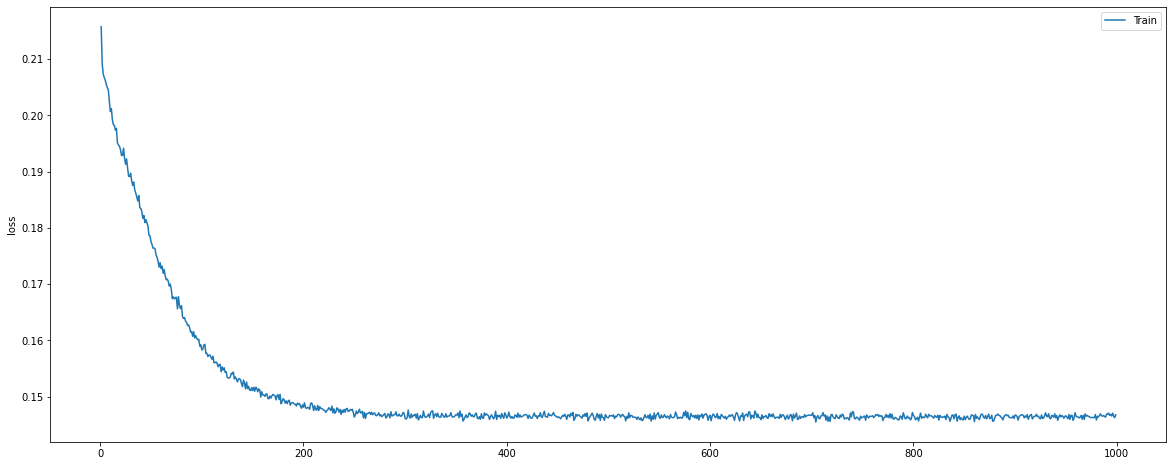

In [17]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class Time2Vec(Layer):
    def __init__(self, kernel_size, periodic_activation='sin'):
        '''
        :param kernel_size:         The length of time vector representation.
        :param periodic_activation: The periodic activation, sine or cosine, or any future function.
        '''
        super(Time2Vec, self).__init__(
            trainable=True,
            name='Time2VecLayer_'+periodic_activation.upper()
        )
        
        self.k = kernel_size
        self.p_activation = periodic_activation
    
    def build(self, input_shape):
        # While i = 0
        self.wb = self.add_weight(
            shape=(1, 1),
            initializer='uniform',
            trainable=True
        )
        
        self.bb = self.add_weight(
            shape=(1, 1),
            initializer='uniform',
            trainable=True
        )
        
        # Else needs to pass the periodic activation
        self.wa = self.add_weight(
            shape=(1, self.k),
            initializer='uniform',
            trainable=True
        )
        
        self.ba = self.add_weight(
            shape=(1, self.k),
            initializer='uniform',
            trainable=True
        )
        
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs, **kwargs):
        '''
        
        :param inputs: A Tensor with shape (batch_size, feature_size, 1)
        :param kwargs:
        :return: A Tensor with shape (batch_size, feature_size, length of time vector representation + 1)
        '''
        bias = self.wb * inputs + self.bb
        if self.p_activation.startswith('sin') :
            wgts = K.sin(K.dot(inputs, self.wa) + self.ba)
        elif self.p_activation.startswith('cos') :
            wgts = K.cos(K.dot(inputs, self.wa) + self.ba)
        else:
            raise NotImplementedError('Neither sine or cosine periodic activation be selected.')
        return K.concatenate([bias, wgts], -1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.k + 1)
    
    

def transformer_encoder(inputs):
    # Normalization and Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=128, num_heads=4, dropout=0.1)(x, x)
    x = tf.keras.layers.Dropout(0.1)(x)

    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=1, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return res


TermInput = tf.keras.Input(
    shape=(X_train.shape[1], X_train.shape[2])
)

# TimeInput = tf.keras.Input(
#     shape=(X_TIME_train.shape[1]))

# W = Time2Vec(1)(TimeInput)
# W = tf.keras.layers.concatenate([TermInput, W], -1)

W = TermInput
# W = tf.keras.layers.Flatten()(W)

# for _ in range(2):
#     W = transformer_encoder(W)
    
# W = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(W)
W = tf.keras.layers.Flatten()(W)
for _ in range(2):
    W = tf.keras.layers.Dense(528)(W)
    W = tf.keras.layers.ReLU()(W)
    W = tf.keras.layers.Dropout(0.1)(W)


W = tf.keras.layers.Dense(Y.shape[1], activation = 'sigmoid')(W)
# W = tf.keras.layers.Reshape((Y_train.shape[2]))(W)

ModelOutput = W
oModel = tf.keras.Model(TermInput, ModelOutput, name = 'TRANSFORMER_MODEL')


oLrSchedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10**2,
    decay_rate=0.9)


oOptimizer = tf.keras.optimizers.Adam(learning_rate=oLrSchedule)
oModel.compile(
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics = tf.keras.metrics.AUC(),
    optimizer=oOptimizer
)

tf.keras.utils.plot_model(oModel, show_shapes=True)

# fit model
oModel.fit(
    X_train, 
    Y_train, 
    epochs= 10**3, 
    batch_size=2**11, 
    verbose=1
)

# show epoch history
dfHistory = pd.DataFrame(oModel.history.history)

plt.figure(figsize = (20, 8))
sns.lineplot(data = dfHistory['loss'].iloc[1:], legend = True, label = 'Train')
plt.show()

# RESULTS

In [18]:
# test model
a_Y_datasets = [Y_train, Y_validation]
a_X_datasets = [X_train, X_validation]
a_labels = ['train', 'validation'] 

1094/1094 [==============================] - 2s 2ms/step


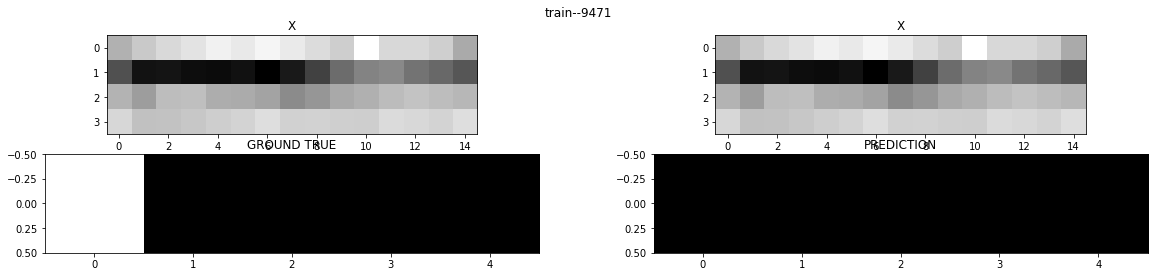

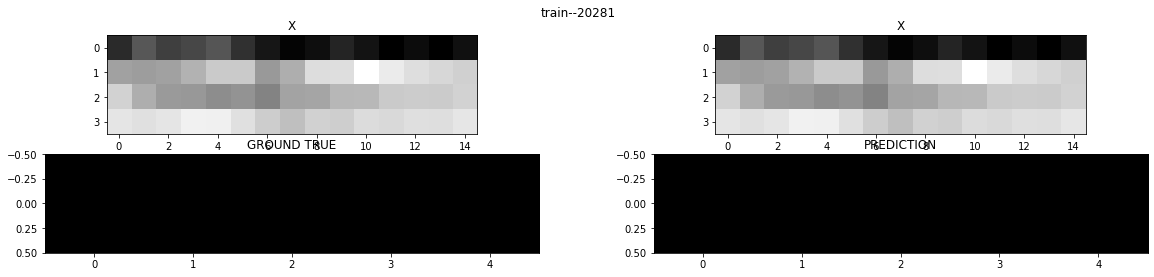

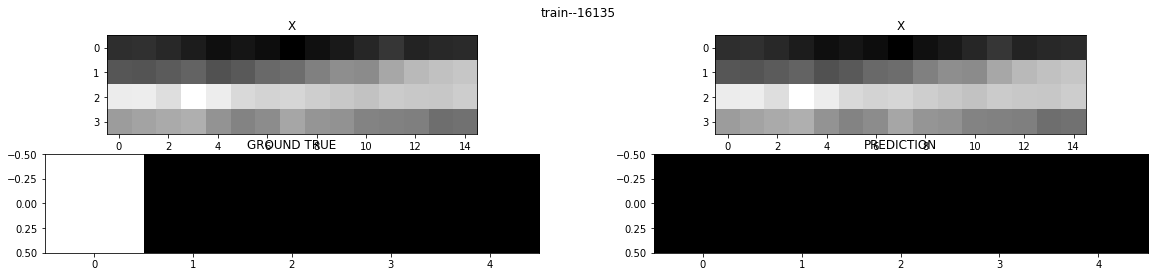

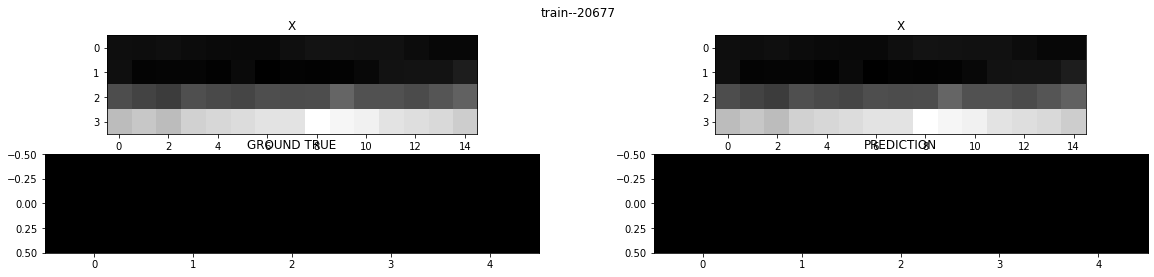

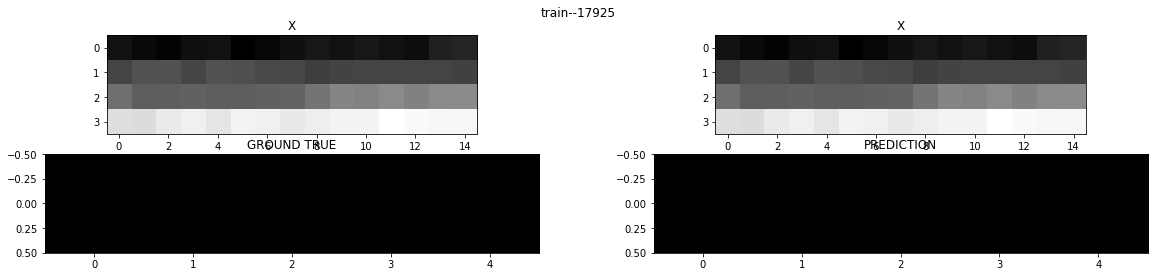

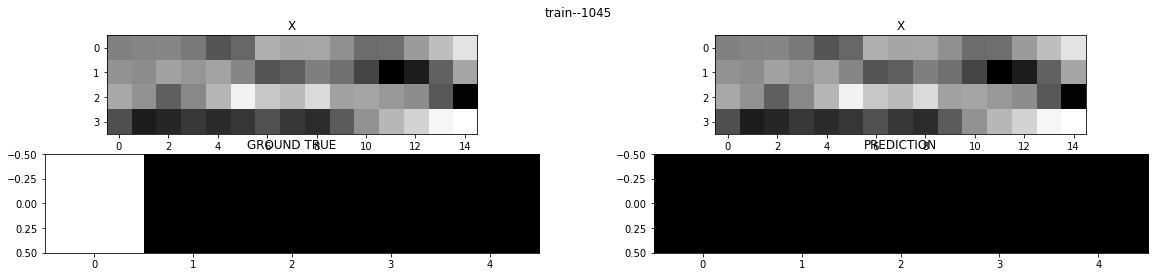

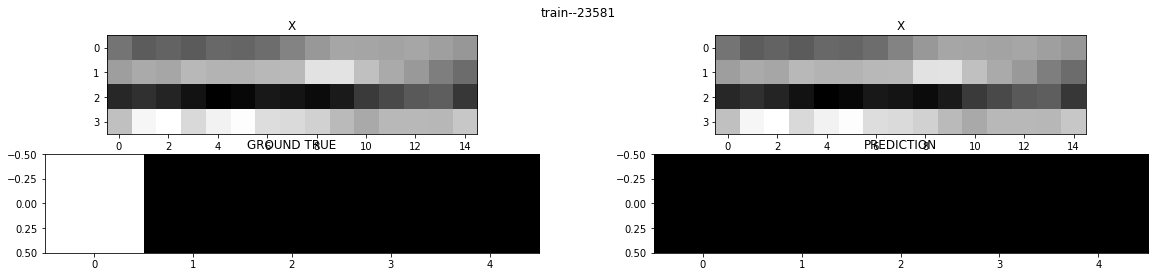

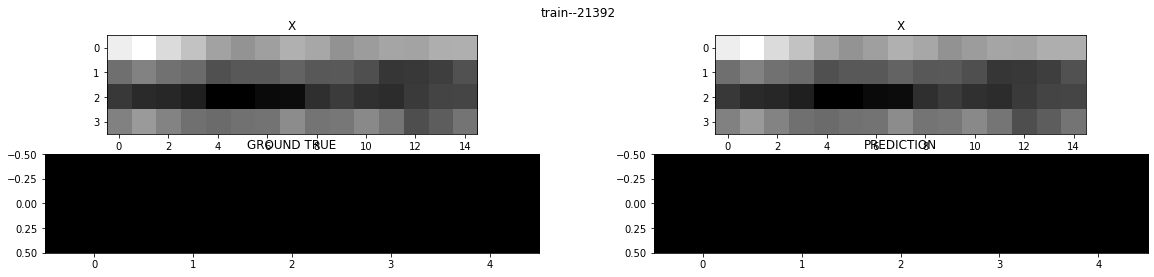

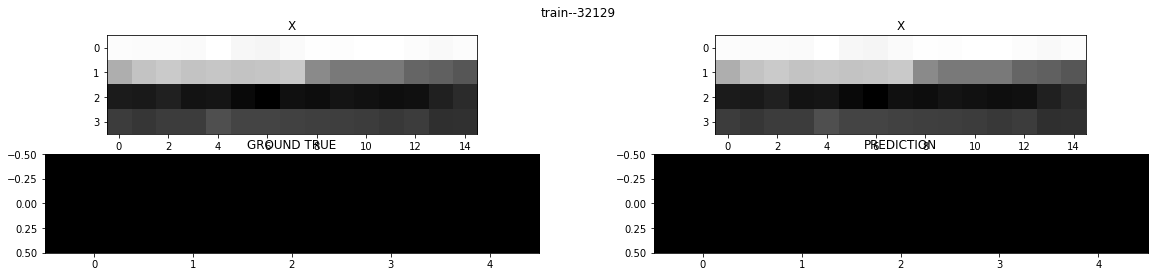

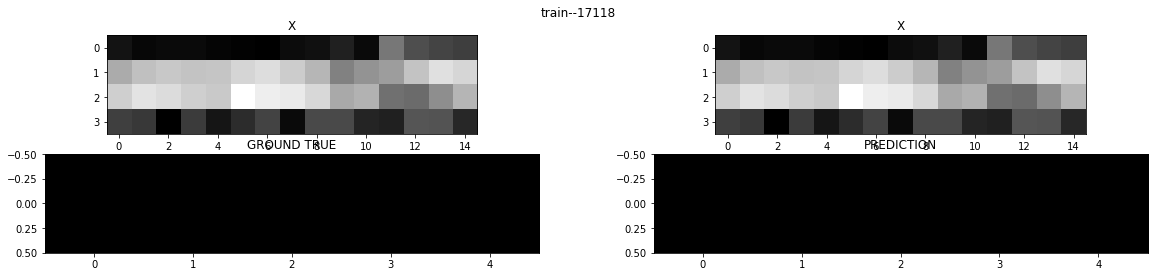

438/438 [==============================] - 1s 2ms/step


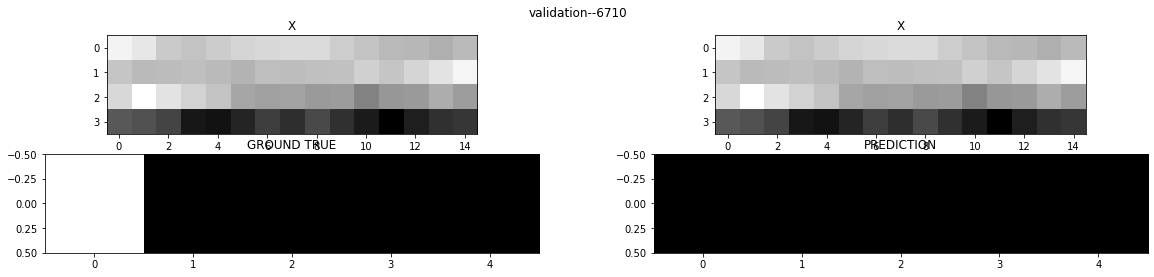

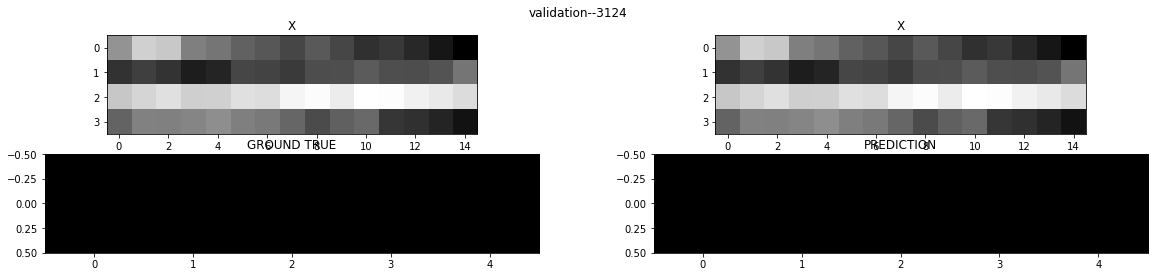

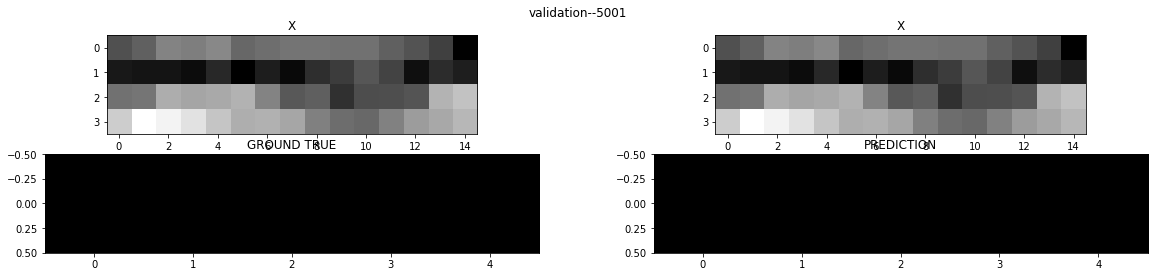

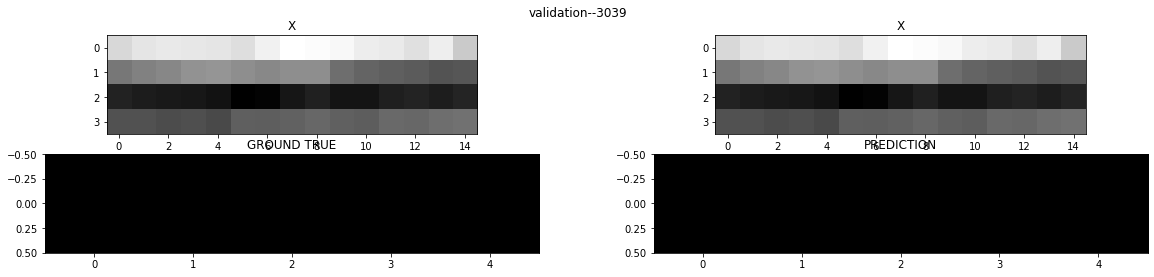

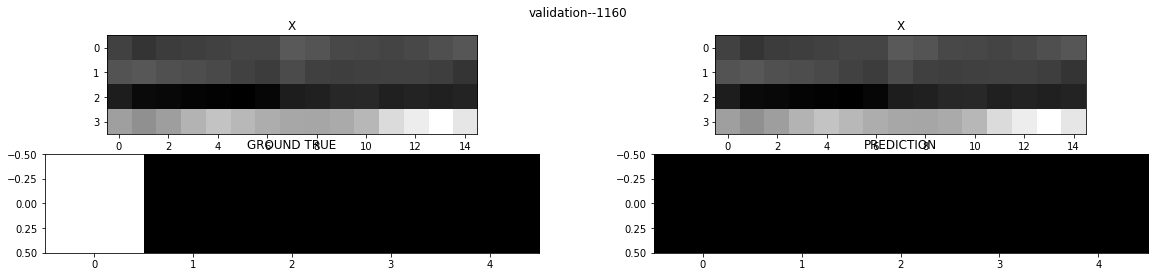

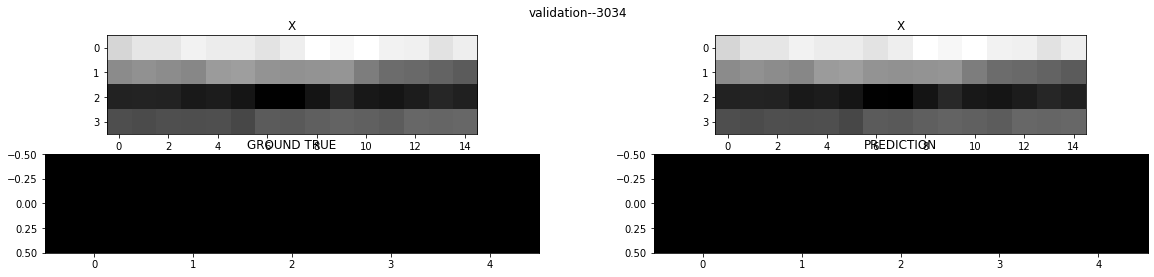

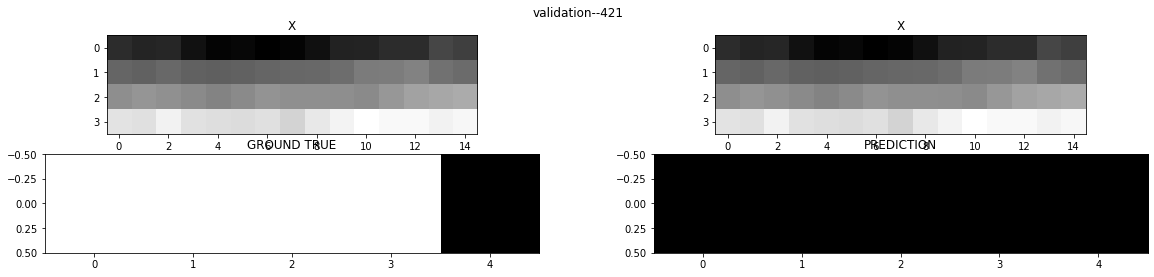

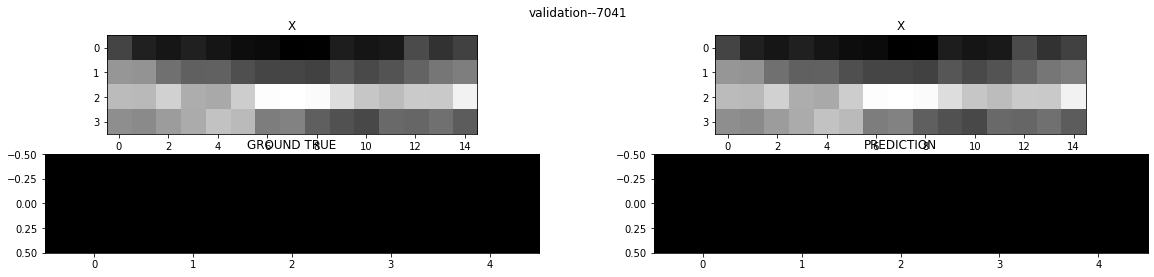

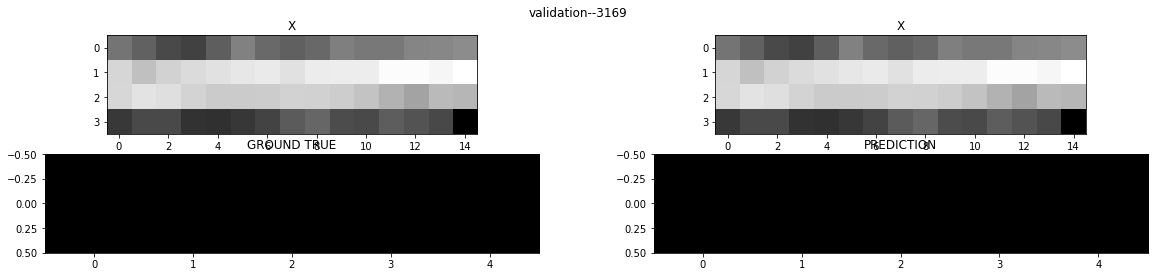

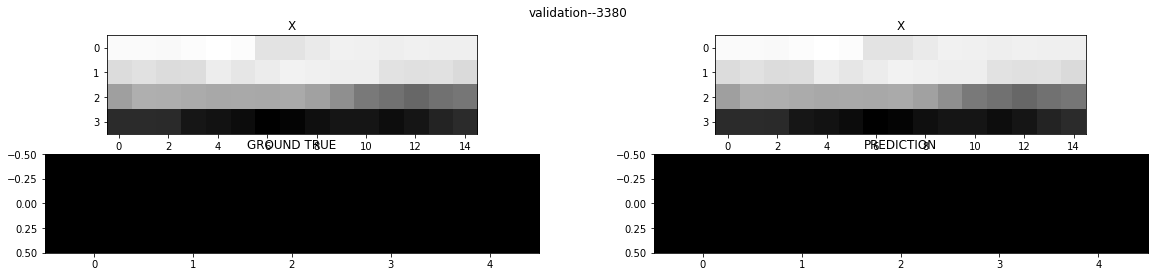

In [20]:
# sample results
for X_to_visualize,Y_to_visualize, sLabel in list(zip(a_X_datasets, a_Y_datasets, a_labels)):
    pred = oModel.predict(X_to_visualize)
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    ground_true = Y_to_visualize
    for i in np.random.randint(low = 0,high = len(X_to_visualize), size = 10):      
        
        fig, axs = plt.subplots(2,2, figsize=(20, 4))
        fig.suptitle('{}--{}'.format(sLabel, i))
        
        axs[0, 0].imshow(X_to_visualize[i], cmap='gray')
        axs[0, 0].set_title('X')

        axs[0, 1].imshow(X_to_visualize[i], cmap='gray')
        axs[0, 1].set_title('X')

                
        axs[1, 0].imshow(ground_true[[i]], cmap='gray')
        axs[1, 0].set_title( 'GROUND TRUE')

        axs[1, 1].imshow(pred[[i]], cmap='gray')
        axs[1, 1].set_title( 'PREDICTION')

        plt.show()

In [21]:
# classification report
for X_to_visualize,Y_to_visualize, sLabel in list(zip(a_X_datasets, a_Y_datasets, a_labels)):
    pred = oModel.predict(X_to_visualize)
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    ground_true = Y_to_visualize
    print(sLabel)
    print(classification_report(ground_true, pred, zero_division = 0))

1094/1094 [==============================] - 2s 2ms/step
train
              precision    recall  f1-score   support

           0       0.81      0.36      0.50      9310
           1       0.89      0.33      0.48      2879
           2       0.93      0.43      0.59      1046
           3       0.93      0.47      0.63       472
           4       0.00      0.00      0.00         0

   micro avg       0.84      0.37      0.51     13707
   macro avg       0.71      0.32      0.44     13707
weighted avg       0.84      0.37      0.51     13707
 samples avg       0.10      0.09      0.09     13707

438/438 [==============================] - 1s 2ms/step
validation
              precision    recall  f1-score   support

           0       0.28      0.10      0.14      2815
           1       0.02      0.00      0.01       784
           2       0.00      0.00      0.00       320
           3       0.00      0.00      0.00       168
           4       0.00      0.00      0.00         0

  

1094/1094 [==============================] - 2s 2ms/step


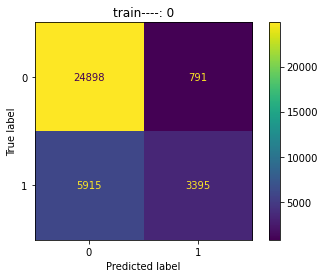

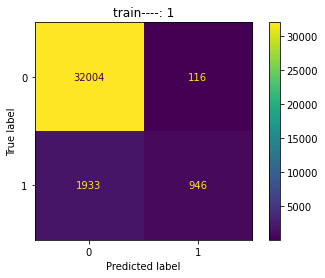

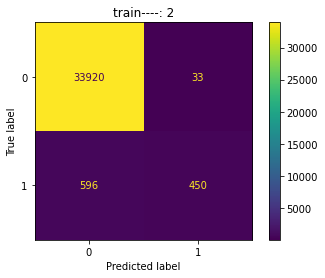

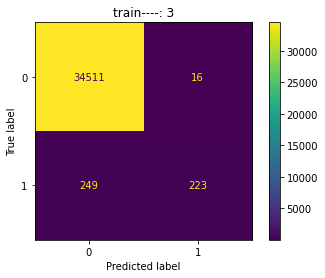

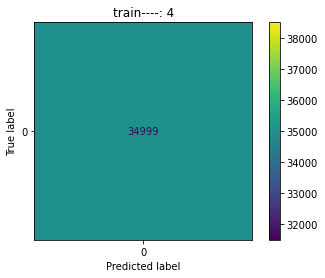

438/438 [==============================] - 1s 2ms/step


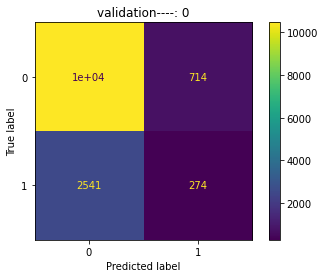

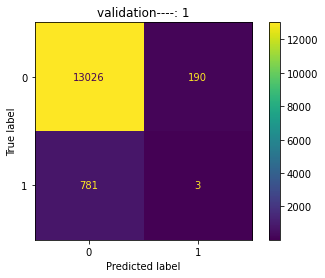

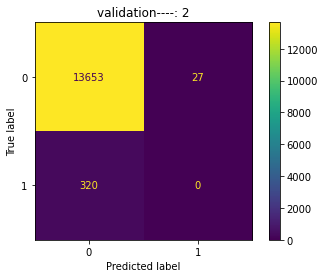

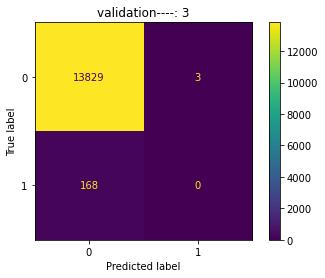

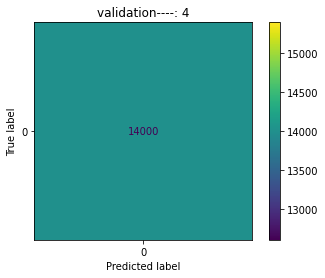

In [22]:
# confusion matrix
for X_to_visualize,Y_to_visualize, sLabel in list(zip(a_X_datasets, a_Y_datasets, a_labels)):
    pred = oModel.predict(X_to_visualize)
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    ground_true = Y_to_visualize

    for i in range(pred.shape[1]):
        oCm = confusion_matrix(ground_true[:, i], pred[:, i])
        oFig = ConfusionMatrixDisplay(confusion_matrix=oCm)
        oFig.plot()
        oFig.ax_.set_title('{}----: {}'.format(sLabel,i))
        plt.show()

# SAVE

In [ ]:
oModel.save(r'Temp\VaswaniModel')